In [4]:
!rm libdevice.10.bc
!ln -s /opt/conda/nvvm/libdevice/libdevice.10.bc ./libdevice.10.bc

# RANDOM SEED = 42
import numpy as np
import random
import tensorflow as tf
import os

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds(42)

In [5]:
# LOAD DATASET

import boto3

bucket_name = 'ct-patches-nogroundtruths'
object_key = 'CT_patches_combined.npz'
download_path = './CT_patches_combined.npz'

s3 = boto3.client('s3')
s3.download_file(bucket_name, object_key, download_path)

print("Downloaded CT_patches_combined.npz")

data = np.load('CT_patches_combined.npz')
patches = data['patches']
labels = data['labels']

print("Label distribution:", np.bincount(labels))

# SPLIT INTO TRAINING & TESTING DATA

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Reshape patches to include channel dimension (grayscale = 1)
patches = patches[..., np.newaxis]  # (N, 32, 32) → (N, 32, 32, 1)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    patches, labels, test_size=0.15, random_state=42, stratify=labels
)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Downloaded CT_patches_combined.npz
Label distribution: [1168556   50004]
Training set: (1035776, 32, 32, 1) (1035776,)
Validation set: (182784, 32, 32, 1) (182784,)


In [7]:
# from sklearn.utils import class_weight
# import os

# # Compute class weights for training labels only
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )

# class_weights_dict = dict(enumerate(class_weights))
# print("Computed class weights:", class_weights_dict)

Computed class weights: {0: 0.5213954270376825, 1: 12.184739900712891}


I0000 00:00:1750911307.318420    1280 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 701 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5
W0000 00:00:1750911307.566712    2136 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /opt/conda/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /opt/conda/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /opt/conda/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ constrained_conv    │ (None, 32, 32, 1) │         25 │ input_layer[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        640 │ constrained_conv… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │        128 │ constrained_conv… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_1[0][0],   │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │    147,584 │ leaky_re_lu_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 16,    │          0 │ conv2d_4[0][0],   │
│                     │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ add_1[0][0]       │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ leaky_re_lu_3[0]

 Total params: 456,397 (1.74 MB)

 Trainable params: 456,141 (1.74 MB)

 Non-trainable params: 256 (1.00 KB)

Stage 1: Training with Binary Crossentropy (Epochs 1–5)
Epoch 1/5


I0000 00:00:1750911314.112825    2130 service.cc:148] XLA service 0x7fe0340cc9e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750911314.112858    2130 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-06-26 04:15:14.282411: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750911314.912044    2130 cuda_dnn.cc:529] Loaded cuDNN version 91001
2025-06-26 04:15:16.074955: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,32,32]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation

    6/16184 ━━━━━━━━━━━━━━━━━━━━ 7:14 27ms/step - accuracy: 0.5018 - auc: 0.5000 - loss: 0.7051 - precision: 0.5012 - recall: 0.6439

I0000 00:00:1750911326.635259    2130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16182/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6768 - auc: 0.7357 - loss: 0.5823 - precision: 0.6297 - recall: 0.8579

2025-06-26 04:22:15.537063: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,32,32]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-26 04:22:15.579343: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}, f32[32,64,32,32]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="


Epoch 1: val_recall improved from -inf to 0.37928, saving model to CT_CCNN_model.h5


16184/16184 ━━━━━━━━━━━━━━━━━━━━ 446s 26ms/step - accuracy: 0.6768 - auc: 0.7357 - loss: 0.5823 - precision: 0.6297 - recall: 0.8579 - val_accuracy: 0.8428 - val_auc: 0.7639 - val_loss: 0.3437 - val_precision: 0.1057 - val_recall: 0.3793
Epoch 2/5
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7180 - auc: 0.7892 - loss: 0.5355 - precision: 0.6688 - recall: 0.8638
Epoch 2: val_recall improved from 0.37928 to 0.44847, saving model to CT_CCNN_model.h5


16184/16184 ━━━━━━━━━━━━━━━━━━━━ 415s 26ms/step - accuracy: 0.7180 - auc: 0.7892 - loss: 0.5355 - precision: 0.6688 - recall: 0.8638 - val_accuracy: 0.8164 - val_auc: 0.7570 - val_loss: 0.3584 - val_precision: 0.1026 - val_recall: 0.4485
Epoch 3/5
16182/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7295 - auc: 0.8014 - loss: 0.5212 - precision: 0.6799 - recall: 0.8673
Epoch 3: val_recall did not improve from 0.44847
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 408s 25ms/step - accuracy: 0.7295 - auc: 0.8014 - loss: 0.5212 - precision: 0.6799 - recall: 0.8673 - val_accuracy: 0.8761 - val_auc: 0.7587 - val_loss: 0.3077 - val_precision: 0.1162 - val_recall: 0.3060
Epoch 4/5
16183/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7368 - auc: 0.8092 - loss: 0.5105 - precision: 0.6864 - recall: 0.8719
Epoch 4: val_recall improved from 0.44847 to 0.56632, saving model to CT_CCNN_model.h5


16184/16184 ━━━━━━━━━━━━━━━━━━━━ 402s 25ms/step - accuracy: 0.7368 - auc: 0.8092 - loss: 0.5105 - precision: 0.6864 - recall: 0.8719 - val_accuracy: 0.7606 - val_auc: 0.7686 - val_loss: 0.4074 - val_precision: 0.0949 - val_recall: 0.5663
Epoch 5/5
16183/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7491 - auc: 0.8211 - loss: 0.4957 - precision: 0.6981 - recall: 0.8777
Epoch 5: val_recall improved from 0.56632 to 0.67978, saving model to CT_CCNN_model.h5


16184/16184 ━━━━━━━━━━━━━━━━━━━━ 400s 25ms/step - accuracy: 0.7491 - auc: 0.8211 - loss: 0.4957 - precision: 0.6981 - recall: 0.8777 - val_accuracy: 0.6976 - val_auc: 0.7711 - val_loss: 0.4583 - val_precision: 0.0880 - val_recall: 0.6798
Restoring model weights from the end of the best epoch: 5.
Stage 2: Training with Hybrid Loss (Epochs 6–20)
Epoch 1/15
16183/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7632 - auc: 0.8353 - loss: 0.2938 - precision: 0.7094 - recall: 0.8916
Epoch 1: val_recall did not improve from 0.67978
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 434s 26ms/step - accuracy: 0.7632 - auc: 0.8353 - loss: 0.2938 - precision: 0.7094 - recall: 0.8916 - val_accuracy: 0.7318 - val_auc: 0.7574 - val_loss: 0.2618 - val_precision: 0.0892 - val_recall: 0.6007
Epoch 2/15
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7810 - auc: 0.8518 - loss: 0.2831 - precision: 0.7280 - recall: 0.8970
Epoch 2: val_recall improved from 0.67978 to 0.78176, saving model to CT_CCNN_model

16184/16184 ━━━━━━━━━━━━━━━━━━━━ 418s 26ms/step - accuracy: 0.7810 - auc: 0.8518 - loss: 0.2831 - precision: 0.7280 - recall: 0.8970 - val_accuracy: 0.6203 - val_auc: 0.7618 - val_loss: 0.3221 - val_precision: 0.0796 - val_recall: 0.7818
Epoch 3/15
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7938 - auc: 0.8627 - loss: 0.2759 - precision: 0.7420 - recall: 0.9010
Epoch 3: val_recall did not improve from 0.78176
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 417s 26ms/step - accuracy: 0.7938 - auc: 0.8627 - loss: 0.2759 - precision: 0.7420 - recall: 0.9010 - val_accuracy: 0.8525 - val_auc: 0.7646 - val_loss: 0.2067 - val_precision: 0.1121 - val_recall: 0.3749
Epoch 4/15
16183/16184 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8058 - auc: 0.8748 - loss: 0.2680 - precision: 0.7565 - recall: 0.9021
Epoch 4: val_recall did not improve from 0.78176
16184/16184 ━━━━━━━━━━━━━━━━━━━━ 417s 26ms/step - accuracy: 0.8058 - auc: 0.8748 - loss: 0.2680 - precision: 0.7565 - recall: 0.9021 - val_acc

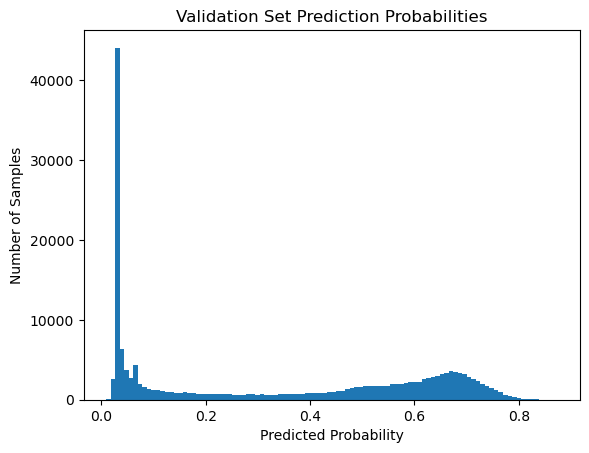

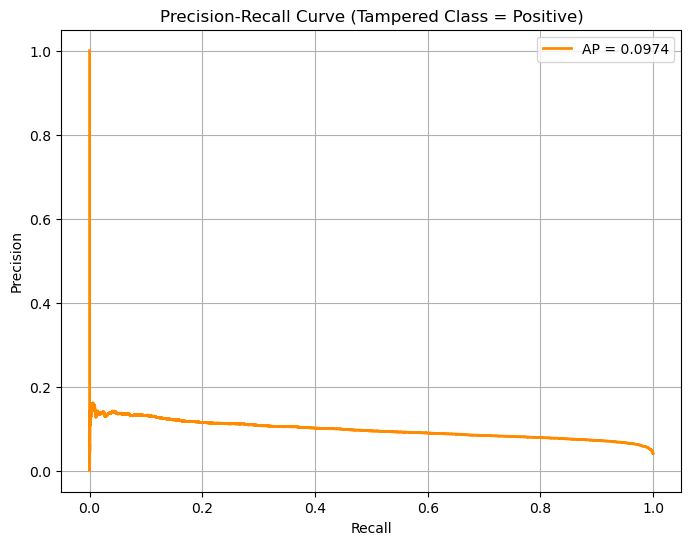

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, Input, Dense, BatchNormalization, 
                                     MaxPooling2D, Dropout, Add, LeakyReLU, 
                                     GlobalAveragePooling2D, Reshape, multiply, 
                                     GlobalMaxPooling2D, Concatenate, Lambda, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import backend as K

# SETTINGS

PATCH_FOLDER = './CT_patches'
PATCH_SIZE = 32
BATCH_SIZE = 64  
EPOCHS = 20
LEARNING_RATE = 1e-4
MODEL_PATH = 'CT_CCNN_model.h5'
VALIDATION_SPLIT = 0.15
L2_REG = 1e-5

# LOSS FUNCTIONS

def focal_loss(gamma=2., alpha=0.5): 
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + \
                 (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        return K.mean(weight * cross_entropy, axis=-1)
    return focal_loss_fixed

def hybrid_loss_with_smoothed_bce(gamma=2.0, alpha=0.55, bce_weight=0.5, smoothing=0.05):
    # Focal loss (no smoothing)
    fl = focal_loss(gamma=gamma, alpha=alpha)
    # Smoothed BCE
    bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=smoothing)

    def loss_fn(y_true, y_pred):
        return bce_weight * bce(y_true, y_pred) + (1 - bce_weight) * fl(y_true, y_pred)

    return loss_fn

# ZERO-SUM HIGH PASS FILTER

class zero_sum_filter(Constraint):
    def __call__(self, w):
        import tensorflow as tf
        w_shape = w.shape
        center = w_shape[0] // 2, w_shape[1] // 2
        mask = tf.ones_like(w)
        mask = tf.tensor_scatter_nd_update(mask, [[center[0], center[1], 0, 0]], [0.])
        w_sum = tf.reduce_sum(w * mask)
        w_center = -w_sum
        w = tf.tensor_scatter_nd_update(w, [[center[0], center[1], 0, 0]], [w_center])
        return w

# CBAM BLOCK

def cbam_block(x, ratio=8):
    channel = x.shape[-1]

    # Channel attention
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)

    shared_dense = Dense(channel // ratio, activation='relu', kernel_regularizer=l2(L2_REG))
    shared_out = Dense(channel, kernel_regularizer=l2(L2_REG))

    avg_out = shared_out(shared_dense(avg_pool))
    max_out = shared_out(shared_dense(max_pool))
    channel_attention = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_attention = Reshape((1, 1, channel))(channel_attention)
    x = multiply([x, channel_attention])

    # Spatial attention
    avg_pool_spatial = Lambda(lambda t: K.mean(t, axis=3, keepdims=True))(x)
    max_pool_spatial = Lambda(lambda t: K.max(t, axis=3, keepdims=True))(x)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid',
                               kernel_regularizer=l2(L2_REG))(concat)
    x = multiply([x, spatial_attention])
    return x

# BUILD CCNN

def build_ccnn(input_shape=(32, 32, 1)):
    inputs = Input(shape=input_shape)

    x = Conv2D(1, (5, 5), padding='same',
               kernel_constraint=zero_sum_filter(),
               kernel_regularizer=l2(L2_REG),
               use_bias=False,
               name='constrained_conv')(inputs)

    # Residual block 1
    res = x
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(res)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(x)
    res = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(L2_REG))(res)
    x = Add()([x, res])
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Residual block 2
    res2 = x
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(res2)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(x)
    res2 = Conv2D(128, (1, 1), padding='same', kernel_regularizer=l2(L2_REG))(res2)
    x = Add()([x, res2])
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Add CBAM
    x = cbam_block(x)

    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_REG))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=l2(L2_REG),
                        pointwise_regularizer=l2(L2_REG))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=l2(L2_REG),
                        pointwise_regularizer=l2(L2_REG))(x)
    x = LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        depthwise_regularizer=l2(L2_REG),
                        pointwise_regularizer=l2(L2_REG))(x)
    x = LeakyReLU(negative_slope=0.1)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(L2_REG))(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(L2_REG))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(LEARNING_RATE),
        loss=hybrid_loss_with_smoothed_bce(gamma=2.0, alpha=0.55, bce_weight=0.5, smoothing=0.05),
        metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),          # 👈 forces val_recall
        AUC(name='auc')
        ]
    )
    
    return model

# CLASS BALANCE IN TRAINING

def balanced_batch_generator(tampered_X, tampered_y, untampered_X, untampered_y, batch_size):
    n = batch_size // 2

    tampered_indices = np.arange(len(tampered_X))
    untampered_indices = np.arange(len(untampered_X))

    while True:
        tampered_sample_idx = np.random.choice(tampered_indices, size=n, replace=True)
        untampered_sample_idx = np.random.choice(untampered_indices, size=n, replace=False)

        batch_X = np.concatenate([tampered_X[tampered_sample_idx], untampered_X[untampered_sample_idx]], axis=0)
        batch_y = np.concatenate([tampered_y[tampered_sample_idx], untampered_y[untampered_sample_idx]], axis=0)

        perm = np.random.permutation(len(batch_y))
        yield batch_X[perm], batch_y[perm]

# SPLIT TRAINING DATA BY LABEL

tampered_mask = (y_train == 1)
untampered_mask = (y_train == 0)

tampered_X_train = X_train[tampered_mask]
tampered_y_train = y_train[tampered_mask]
untampered_X_train = X_train[untampered_mask]
untampered_y_train = y_train[untampered_mask]

# COMPILE CCNN

model = build_ccnn()
model.summary()

# UPDATE CCNN & EARLY STOPPING

checkpoint = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_recall',
    mode='max',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# GENERATE TRAINING BATCHES

train_generator = balanced_batch_generator(
    tampered_X_train, tampered_y_train,
    untampered_X_train, untampered_y_train,
    batch_size=BATCH_SIZE
)

steps_per_epoch = len(y_train) // BATCH_SIZE

# TRAIN CCNN

# Define BCE and hybrid loss separately
bce_loss = tf.keras.losses.BinaryCrossentropy()
hybrid = hybrid_loss_with_smoothed_bce(gamma=2.0, alpha=0.55, bce_weight=0.5, smoothing=0.05)

# Stage 1 (Epochs 1-5): Train with BCE
print("Stage 1: Training with Binary Crossentropy (Epochs 1–5)")
model.compile(
    optimizer=Adam(LEARNING_RATE),
    loss=bce_loss,
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

history_bce = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, earlystop],
    shuffle=False
)

# Stage 2 (Epochs 6-Stop): Train with Hybrid Loss
print("Stage 2: Training with Hybrid Loss (Epochs 6–20)")
model.compile(
    optimizer=Adam(LEARNING_RATE),
    loss=hybrid,
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

history_hybrid = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS - 5,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, earlystop],
    shuffle=False
)

# THRESHOLD EVALUATION

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score

y_val_probs = model.predict(X_val)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for thresh in thresholds:
    y_val_pred = (y_val_probs > thresh).astype(int)
    print(f"--- Threshold: {thresh} ---")
    print(classification_report(y_val, y_val_pred, digits=4))
    print(f"AUROC (using probs): {roc_auc_score(y_val, y_val_probs):.4f}\n")

# PROBABILITY VS. NUMBER OF SAMPLES GRAPH

plt.hist(y_val_probs, bins=100)
plt.title("Validation Set Prediction Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Samples")
plt.show()

# Get predicted probabilities
y_scores = y_val_probs.ravel() 

# PRECISION VS. RECALL GRAPH

# Compute PR curve & area under PR curve
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
avg_precision = average_precision_score(y_val, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AP = {avg_precision:.4f}", color="darkorange", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Tampered Class = Positive)")
plt.grid(True)
plt.legend(loc="upper right")
plt.show()